<h1> Deep learning using PyTorch : Image segmentation</h>

<H>  Set up  gpu runtime environment

In [6]:
# Installing required Libraries : Pytorch->SegmentationModels, GitHub dependencies -> Albumations, Upgrade opencv-contrib-python
#%pip install segmentation-models-pytorch
#%pip install -U git+https://github.com/albumentations-team/albumentations
#%pip install --upgrade opencv-contrib-python

![Untitled Diagram.drawio (2).png](Ã¢ÂÂ¦NiWmUQMAgYBAwCBgGDgEHAIGAQMAgYBNY8Ai5Dttb8GJkGGgQMAgYBg4BBwCBgEDAIGAQMAucgAv8/IbsD7n49eDYAAAAASUVORK5CYII=)

# Download DATASETS

In [7]:
#!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

# Some Common Imports

In [8]:
import sys
sys.path.append('C:/Users/DHEEPAK/Desktop/MachineLearning/1_ML_Projects/Coursera Project/Human-Segmentation-Dataset-master')

In [9]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Setup Configuration

In [10]:
CSV_FILE='C:/Users/DHEEPAK/Desktop/MachineLearning/1_ML_Projects/Coursera Project/Human-Segmentation-Dataset-master/train.csv'#/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR='/content/'
DEVICE= 'cuda'

EPOCHS=25
LR=0.003
IMG_SIZE=320
BATCH_SIZE=16


ENCODER='timm-efficientnet-b0'
WEIGHTS='imagenet'

In [11]:
df= pd.read_csv(CSV_FILE)
df.head()



FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/DHEEPAK/Desktop/MachineLearning/1_ML_Projects/Coursera Project/Human-Segmentation-Dataset-master/train.csv'

In [ ]:
df.tail()

,masks,images
285,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
286,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
287,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
288,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
289,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row= df.loc[273]     # Specifies row in .csv
image_path= row.images
mask_path=row.masks

image= cv2.imread(image_path)
image-cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask=cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) /255.0


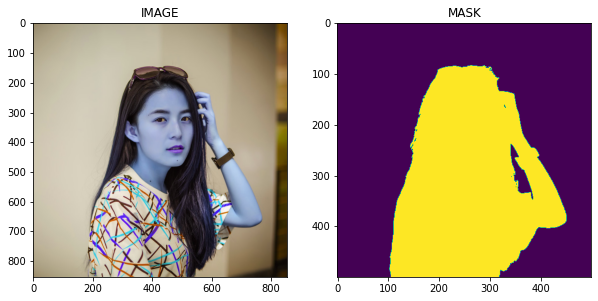

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('MASK')
ax2.imshow(mask)

In [ ]:
train_df, valid_df= train_test_split(df, test_size = 0.2, random_state = 42)

#The number 42 just corresponds to the seed of Randomness, you can use another number, for example 101. Each time that you run your model, the values selected will be the same, but if you change this number the values selected will be different and your accuracy could have variety but you will be sure that your model is robust if your accuracy keeps following the same. Best regards.
#Random_state can be 0 or 1 or any other integer. It should be the same value if you want to validate your processing over multiple runs of the code. By the way, I have seen random_state=42 used in many official examples of scikit.
#the random_state parameter is used for initializing the internal random number generator, which will decide the splitting of data into train and test indices in your case.
#If random_state is None or np.random, then a randomly-initialized RandomState object is returned.

# Task 3 : Augmentation Functions<br>
albumentation documentation : https://albumentations.ai/docs/

In [ ]:
#%pip install albumentations

In [ ]:
import albumentations as A

def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p= 0.5),
        A.VerticalFlip(p= 0.5)
    ])
def get_valid_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE)
    ])

# Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations):
        
        self.df=df
        self.augmentations=augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        row= self.df.iloc[idx]

        image_path = row.images
        mask_path =  row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # (Height , Width, Channel)
        mask = np.expand_dims(mask, axis =-1)

        if self.augmentations:
            data= self.augmentations(image = image, mask= mask)
            image = data['image']
            mask = data['mask']

        #( Height , Width, Channel) -> (Channel, Height, Width)
        image = np.transpose (image, (2,0,1)).astype(np.float32)  #Transposed Image
        mask = np.transpose (mask, (2,0,1)).astype(np.float32)    #Transposed Mask

        #Convert to numpy 
        image = torch. Tensor(image)/ 255.0
        mask = torch.round(torch.Tensor(mask)/ 255.0)

        return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset= SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print("Size of Trainset  : ", len(trainset))
print("Size of ValidSet : ", len(validset))

Size of Trainset  :  232
Size of ValidSet :  58


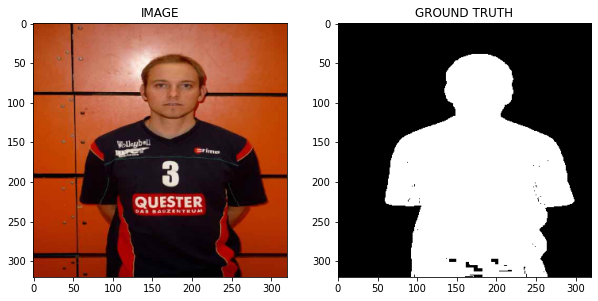

In [ ]:
idx=12 # THis looks cool

image, mask = trainset[idx]
helper.show_image(image, mask)

# Load DataSet into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True)  # Trainset=232 , batchSize = 16 , so , trainloader= Trainset/ batchsize = 15
validloader = DataLoader(validset, batch_size= BATCH_SIZE)  # Validset =58, batchsize =16, so, Validloader = validset/ batchsize = 4

In [ ]:
print("Total no. of batches in trainloader : ",len(trainloader))
print("Total no. of batches in validloader : ",len(validloader))

Total no. of batches in trainloader :  15
Total no. of batches in validloader :  4


In [ ]:
for image, mask in trainloader:    # To take the first image 
    break

In [ ]:
print("One batch image shape : ", image.shape, " <- Batchsize, No. of channel, IMAGE_SIZE, IMAGE_SIZE")
print("One batch mask shape : ", mask.shape)

One batch image shape :  torch.Size([16, 3, 320, 320])  <- Batchsize, No. of channel, IMAGE_SIZE, IMAGE_SIZE
One batch mask shape :  torch.Size([16, 1, 320, 320])


# Create Segmentation Model<br>
segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn  
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.arc = smp.Unet(
            encoder_name= ENCODER,
            encoder_weights=WEIGHTS,
            in_channels= 3,
            classes = 1,
            activation = None
        )
    
    def forward(self, images, masks =None):
        
        logits = self.arc(images)

        if masks !=None:
            loss1= DiceLoss(mode='binary')(logits, masks)   # https://smp.readthedocs.io/en/latest/ select using this link
            loss2= nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2
        
        return logits

In [ ]:
model =SegmentationModel()
model.to(DEVICE)

AssertionError: Torch not compiled with CUDA enabled

# Create Train & Validation Function

In [ ]:
def train_fn(data_loader, model, optimizer):
    
    model.train()
    total_loss=0.0

    for images, masks in tqdm(data_loader): #tqdm is a library in Python which is used for creating Progress Meters or Progress Bars.
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [ ]:
def eval_fn(data_loader, model):
    model.eval()
    total_loss=0.0

    with torch.no_grad():
        for images, masks in tqdm(data_loader):  #tqdm is a library in Python which is used for creating Progress Meters or Progress Bars.
            
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)

            total_loss += loss.item()

    return total_loss / len(data_loader)

# Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)

if valid_loss < best_valid_loss:    # To get the efficient model 
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED MODEL")
    best_valid_loss = valid_loss

print ("Epoch : ", i+1," Train_loss : ",train_loss," Valid_loss : ", valid_loss)

 60%|██████    | 9/15 [06:34<04:22, 43.81s/it]


KeyboardInterrupt: 

# Inference

In [ ]:
idx= 83

model.load_state_dict(torch.load('best_model.pt'))  # Best model only available after Training process is done

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))  #( Channel, Height, Width) -> (1, Channel, Height, Width)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask>0.5) *0.1

NameError: name 'model' is not defined

In [ ]:
helper. show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

*Copyright 2025 Ardent, Inc.*